In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import re
from typing import List

In [14]:
def merge_data(_df_list: List[pd.DataFrame]) -> pd.DataFrame:
    """
    merges the dataframes according to their primary/foreign keys
    :param _df_list: list of dataframes to be merged
    :return: the merged dataframe
    """
    # set up internal parameters
    suffixes = ['_1', '_2']
    r = re.compile('\w*Id')

    # set up variables based on input
    num = len(_df_list)  # length of the list
    to_select = list(range(1,num))  # list of indexes of dataframe to be merged
    remaining = set(range(1,num))  # set of remaining indexes of dataframes yet to be merged

    # get all the '<something>id' columns for each dataframe
    id_list = [set(filter(r.match, table)) for table in _df_list]
    # set up the merged dataframe, 'mg_df'
    mg_df = _df_list[0]
    mg_id = id_list[0]  # set the id set of the merged dataframe as the first dataframe's id set

    # start merging dataframes
    while True:
        merge_flag = 0  # flag indicating if a while-true run has merged any new dataframe
        for index in to_select:
            intersect = mg_id.intersection(id_list[index])
            all_col_intersect = set(mg_df.columns).intersection(set(_df_list[index].columns))
            # iterate through the remaining dataframe
            # and merge those with common id(s)
            if (index in remaining) and intersect:
                if all_col_intersect == intersect:
                    mg_df = pd.merge(mg_df, _df_list[index], on=list(intersect), how='left')
                else:
                    # if there are other common columns than the ids, set suffixes
                    mg_df = pd.merge(mg_df, _df_list[index], on=list(intersect), how='left', suffixes=suffixes)
                # add the new ids into the total id set of the merged dataframe
                mg_id = mg_id.union(set(id_list[index]))
                remaining.remove(index)  # remove the index of the added dataframe
                merge_flag = 1
        if not remaining:
            break  # break if there is no more dataframe to be added
        if not merge_flag:  # if no new dataframe was merged in this while-true run
            print('Error: no common "id" columns found')
            break  # breaks
    return mg_df


def process_data(mg_df: pd.DataFrame, normal_status=True) -> pd.DataFrame:
    """
    process the data for analysis:
    1. filter normal status
    2. add total laps for each record
    3. add total pit stops for each record
    4. calculate the proportion of lap when the driver pit for each pit record
    5. calculate how far the lap proportion deviates from the ideal even distribution for each pit record
    :param mg_df: the merged dataframe
    :param normal_status: if filter the dataframe with records that are finished or +? laps away from the finished
    :return: the processed dataframe
    """
    # 1. filtering normal status
    if normal_status:
        _status_select = [1, 11, 12, 13, 14, 15, 16, 17, 18, 19]
        mg_df.drop(mg_df[~mg_df['statusId'].isin(_status_select)].index, inplace=True)
    # 2&3. add total laps & total pit stops for each record
    _total_laps = mg_df[(mg_df['positionOrder'] == 1) & (mg_df['stop'] == 1)].reset_index(drop=True)[['raceId', 'laps']]
    _total_laps.columns = [str(_total_laps.columns[0]), 'total_laps']
    _total_stops = mg_df.groupby(by=['raceId', 'driverId'], as_index=False)['stop'].max()
    _total_stops.columns = list(_total_stops.columns[:2]) + ['total_stops']
    # 4. calculate the proportion of lap when the driver pit for each pit record
    mg_df = pd.merge(mg_df, _total_laps, on='raceId')
    mg_df = pd.merge(mg_df, _total_stops, on=['raceId', 'driverId'])
    # 5. calculate how far the lap proportion deviates from the ideal even distribution for each pit record
    mg_df['lap_prop'] = mg_df.apply(lambda x: x['lap']/x['total_laps'], axis=1)
    mg_df['abs_err'] = mg_df.apply(lambda x: abs(x['stop']/(x['total_stops']+1) - x['lap_prop']), axis=1)
    return mg_df


def pit_stop_group(df: pd.DataFrame) -> dict:
    """
    group the records by the total number of pit stops of each racing record
    :param df: the merged and processed dataframe
    :return: a dictionary with total pit numbers as keys and dataframe of records as values
    """
    max_num = df['total_stops'].max()
    _df_dict = {}
    for i in range(1, max_num+1):
        _df_dict[i] = df[df['total_stops']==i][['stop','positionOrder','lap_prop']]
    return _df_dict


def distribution_plot(_df_dict: dict, show_mean=True, show_description=True, save_fig=False):
    """
    d
    :param save_fig:
    :param show_description:
    :param show_mean:
    :param _df_dict:
    :return:
    """
    bins = np.linspace(0,1,50)
    color_bin = ['tab:blue', 'tab:orange', 'lightcoral']
    color_bin2 = ['deepskyblue', 'gold', 'crimson']
    max_num_of_stops = 3

    for ps_num in range(1, max_num_of_stops+1):
        plt.figure(figsize=(8,6))
        _df_tmp = _df_dict[ps_num]
        _df_list = [_df_tmp[_df_tmp['stop'] == i]['lap_prop'] for i in range(1, ps_num+1)]
        plot_count = 0
        if show_description: print('////////////////////////////////////////////////////////////////////////////////////////')
        print('Total Pit Stops: ', ps_num)
        for df in _df_list:
            plt.hist(df, bins, alpha=0.7, color=color_bin[plot_count])
            df_mean = round(df.mean(), ndigits=3)
            df_std = round(df.std(), ndigits=3)
            if show_mean: plt.axvline(x=df_mean, color=color_bin2[plot_count], linewidth=4)
            plot_count += 1
            if not show_description: continue
            print('No. ', plot_count, ' pit stop: ', 'mean = ', df_mean, ' std = ', df_std)
            perc_1 = len(df[(df <= df_mean + df_std) & (df >= df_mean - df_std)])/len(df)
            perc_2 = len(df[(df <= df_mean + 2*df_std) & (df >= df_mean - 2*df_std)])/len(df)
            perc_1 = round(100*perc_1, ndigits=1)
            perc_2 = round(100*perc_2, ndigits=1)
            print(f'    {perc_1}% within mean ± 1 std')
            print(f'    {perc_2}% within mean ± 2 std')
        if save_fig: plt.savefig(f'image/hypo2/distribution_{ps_num}.png')
        plt.show()

In [15]:
# Load data
pit = pd.read_csv('data/pit_stops.csv')
results = pd.read_csv('data/results.csv')
status = pd.read_csv('data/status.csv')

In [17]:
# Process the data files
merge_df = merge_data([pit, results, status])
merge_df = process_data(merge_df)
df_dict = pit_stop_group(merge_df)

In [18]:
merge_df

,raceId,driverId,stop,lap,time_1,duration,milliseconds_1,resultId,constructorId,number,...,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId,status,total_laps,total_stops,lap_prop,abs_err
0,841,153,1,1,17:05:23,26.898,26898,20789,5,19,...,41,10,1:30.467,211.025,11,+1 Lap,58,3,0.017241,0.232759
1,841,153,2,17,17:31:06,24.463,24463,20789,5,19,...,41,10,1:30.467,211.025,11,+1 Lap,58,3,0.293103,0.206897
2,841,153,3,35,17:59:45,26.348,26348,20789,5,19,...,41,10,1:30.467,211.025,11,+1 Lap,58,3,0.603448,0.146552
3,841,17,1,11,17:20:48,23.426,23426,20783,9,2,...,50,3,1:29.600,213.066,1,Finished,58,3,0.189655,0.060345
4,841,17,2,26,17:44:29,22.520,22520,20783,9,2,...,50,3,1:29.600,213.066,1,Finished,58,3,0.448276,0.051724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7913,1076,847,1,23,15:38:51,18.479,18479,25448,131,63,...,53,4,1:21.495,233.152,1,Finished,58,1,0.396552,0.103448
7914,1076,4,1,39,16:05:24,18.796,18796,25462,214,14,...,57,2,1:20.846,235.024,11,+1 Lap,58,2,0.672414,0.339080
7915,1076,4,2,53,16:25:28,18.394,18394,25462,214,14,...,57,2,1:20.846,235.024,11,+1 Lap,58,2,0.913793,0.247126
7916,1076,825,1,39,16:05:30,19.111,19111,25459,210,20,...,44,15,1:23.071,228.729,11,+1 Lap,58,1,0.672414,0.172414


In [19]:
# Plot distribution of Pit Stops, grouped by total number of pit stops
# distribution_plot(df_dict, show_mean=False, show_description=False)

////////////////////////////////////////////////////////////////////////////////////////
Total Pit Stops:  1
No.  1  pit stop:  mean =  0.416  std =  0.147
    66.9% within mean ± 1 std
    95.7% within mean ± 2 std


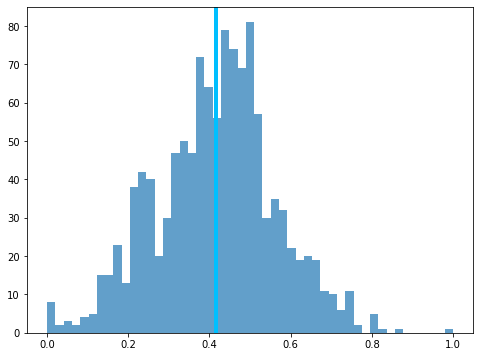

////////////////////////////////////////////////////////////////////////////////////////
Total Pit Stops:  2
No.  1  pit stop:  mean =  0.252  std =  0.118
    71.7% within mean ± 1 std
    95.8% within mean ± 2 std
No.  2  pit stop:  mean =  0.62  std =  0.134
    72.9% within mean ± 1 std
    93.1% within mean ± 2 std


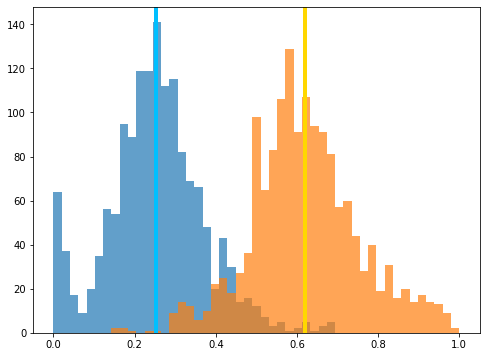

////////////////////////////////////////////////////////////////////////////////////////
Total Pit Stops:  3
No.  1  pit stop:  mean =  0.174  std =  0.098
    66.6% within mean ± 1 std
    97.5% within mean ± 2 std
No.  2  pit stop:  mean =  0.427  std =  0.155
    74.4% within mean ± 1 std
    92.6% within mean ± 2 std
No.  3  pit stop:  mean =  0.698  std =  0.13
    74.9% within mean ± 1 std
    93.9% within mean ± 2 std


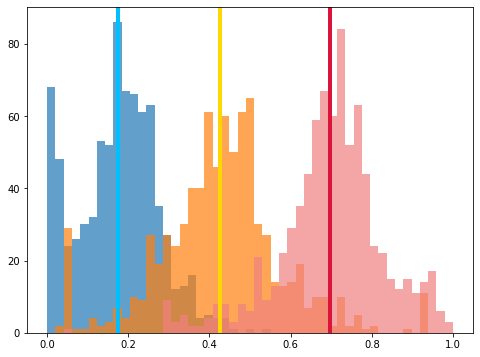

In [20]:
# Adding description for the distribution plot
distribution_plot(df_dict, save_fig=True)

In [21]:
# Run T Tests on the data group pairs
df_list = []
for ps_num in range(1,4):
    df_tmp = df_dict[ps_num]
    df_list += [df_tmp[df_tmp['stop'] == i]['lap_prop'] for i in range(1, ps_num+1)]

In [22]:
p2 = ttest_ind(df_list[1], df_list[2]).pvalue
print('2 pits, p value of T test:', p2, '< alpha = 0.05')

2 pits, p value of T test: 0.0 < alpha = 0.05


In [23]:
p3_1 = ttest_ind(df_list[3], df_list[4]).pvalue
p3_2 = ttest_ind(df_list[3], df_list[5]).pvalue
p3_3 = ttest_ind(df_list[4], df_list[5]).pvalue
print('3 pits, max p value of T test:', max(p3_1, p3_2, p3_3), '< alpha = 0.05')

3 pits, max p value of T test: 5.142138068782536e-225 < alpha = 0.05
